In [0]:
# image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
# 1. download data

In [11]:
path = untar_data(URLs.CAMVID)
path

PosixPath('/root/.fastai/data/camvid')

In [12]:
path_lbl = path/"labels"
path_img = path/"images"
path_lbl,path_img

(PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'))

In [0]:
# 2. show data

In [13]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05160.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00570.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00901.png')]

In [14]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01800_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03360_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08043_P.png')]

In [0]:
# show image

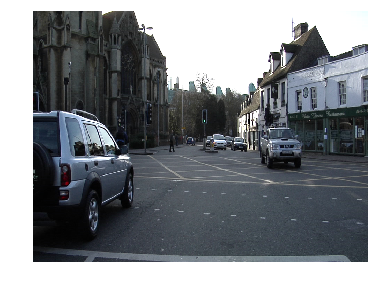

In [15]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(6,6))

In [0]:
# inout one image file name and return the related lable file name
# input img
# output: mask related

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
# show labels (mask)
# alpha: for mask DataBunch, you can define alpha to set opacity for the mask
# 1.0 - means you will not see image

('0016E5_05160', '.png')

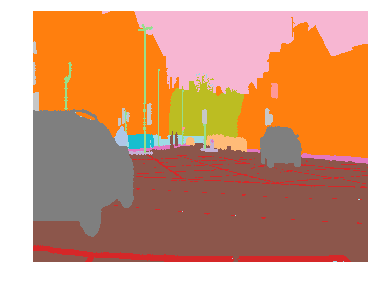

In [20]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(6,6), alpha=1)
img_f.stem, img_f.suffix

In [21]:
src_size = np.array(mask.shape[1:])
mask.shape, src_size, mask.data

(torch.Size([1, 720, 960]),
 array([720, 960]),
 tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [22]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
# 3. dataset

In [23]:
size = src_size // 2

# the bs (batch size) depends on the available GPU RAM
# get free memory (in MBs) for the currently selected gpu id, after emptying the cache
# if you run out of memory, and may also need to decrease bs
free = gpu_mem_get_free_no_cache()
if free > 8200: 
    bs = 8
else:
    bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
data = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes)
       .transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [0]:
# src = (SegmentationItemList.from_folder(path_img)
#        .split_by_fname_file('../valid.txt')
#        .label_from_func(get_y_fn, classes=codes))

In [0]:
# data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

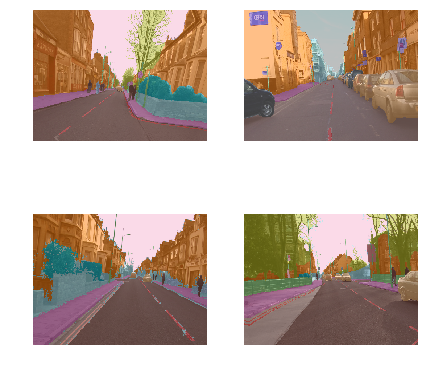

In [25]:
data.show_batch(2, figsize=(6,6))

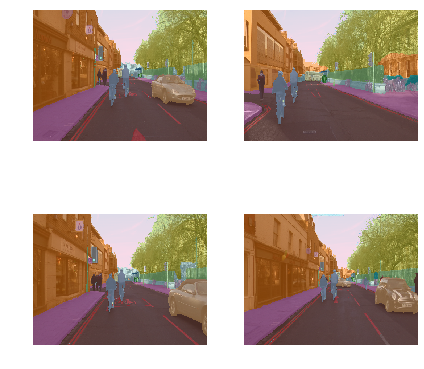

In [26]:
# DatasetType: Enum = [Train, Valid, Test, Single, Fix] mean training, validation and test dataset/dataloader.
data.show_batch(2, figsize=(6,6), ds_type=DatasetType.Valid)

In [0]:
# 4. load model

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
void_code

30

In [0]:
# metrics:acc_camvid (create our own accuracy without void of the class)
# the difference between input and target mask

In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
# wd: weight decay for overfitting (weight decay will be removed from batchnorm layers)

In [0]:
wd = 1e-2

In [0]:
# encoder based on models (resnet34)
# decode:up-convolution
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


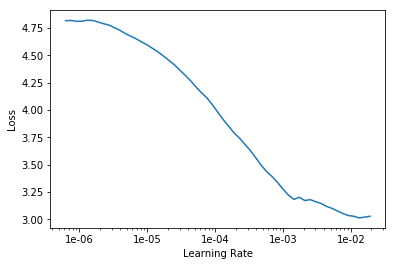

In [45]:
lr_find(learn)
learn.recorder.plot()

In [0]:
# slice(start, end) or slice(end)
# pct_start: you can have lr both increase and decrease during same epoch. pct_start is the percentage of iterations (rise) per epoch
lr=3e-3 # from lr image

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.276735,0.867542,0.801235,03:56
1,0.842620,0.649767,0.838956,03:27
2,0.705193,0.558948,0.858799,03:26
3,0.862460,0.679355,0.838351,03:26
4,0.700252,0.546715,0.842731,03:25
5,0.621174,0.471413,0.877114,03:24
6,0.561707,0.478367,0.869571,03:24
7,0.546160,0.444477,0.877595,03:23
8,0.531185,0.456076,0.876728,03:23
9,0.460147,0.336818,0.902214,03:23


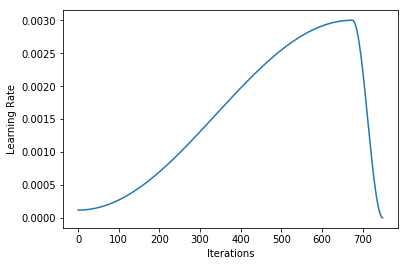

In [35]:
# display the pct_start
learn.recorder.plot_lr()

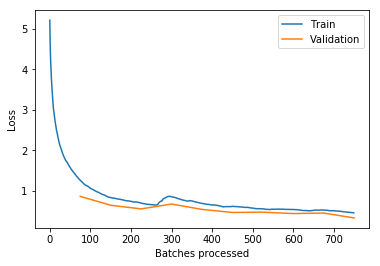

In [37]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1')

In [39]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

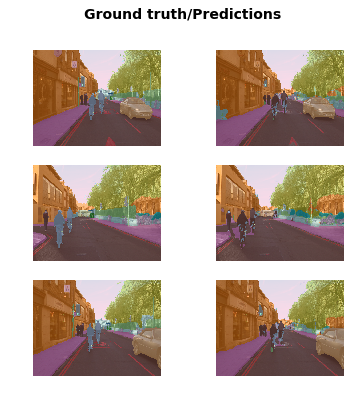

In [40]:
learn.show_results(rows=3, figsize=(6,6))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400, lr/4)

In [43]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.400126,0.327106,0.904099,03:32
1,0.382154,0.321903,0.905499,03:31
2,0.373964,0.318547,0.908700,03:32
3,0.368022,0.328206,0.903856,03:32
4,0.355753,0.328724,0.896369,03:31
5,0.345497,0.325753,0.908415,03:31
6,0.338310,0.395776,0.885484,03:31
7,0.332033,0.324937,0.914027,03:31
8,0.319494,0.341070,0.900575,03:31
9,0.312805,0.303856,0.909873,03:30


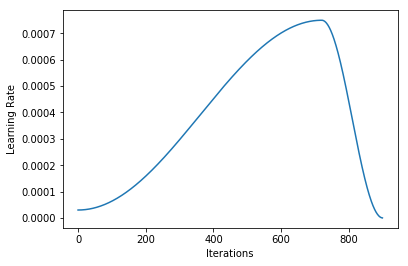

In [44]:
learn.recorder.plot_lr()

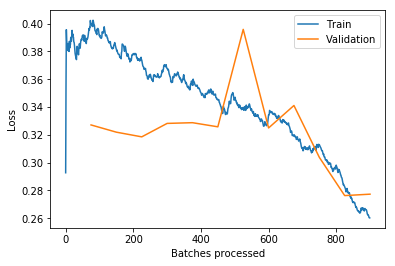

In [45]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2')

In [0]:
# go big

In [56]:
# destroy will release all the memory consuming parts of it, while leaving an empty shell - the learn object will still be there, but you won’t be able to do anything with it.
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")
bs = 1

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 10956MB of GPU RAM free


In [0]:
data = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes)
       .transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
# stage 1

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


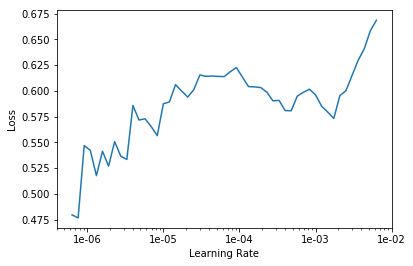

In [60]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [55]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time


RuntimeError: ignored

In [0]:
learn.recorder.plot_lr()

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
# stage 2

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.recorder.plot_lr()

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
# show results

In [0]:
learn.show_results(rows=3, figsize=(10,10))